# Introduction to (deep) Probabilistic Graphical models - Homework 1

### Maxence Gélard

This notebook provides the Python code for the implementation of the different models, as well as the functions used to generate the figures attached in the report. It is divided in the same way as the report, with respectively a first part on Linear Classification and a second part on Gaussian Mixture Models and Expectation-Maximization algorithm.

In [1]:
from collections import defaultdict
from typing import List, Dict

import matplotlib.pyplot as plt
import numpy as np
import pyreadr
from sklearn.cluster import KMeans

np.random.seed(1)

## 1 - Linear Classification

Let's first define a helper function in order to load the datasets:

In [2]:
def load_dataset(file_name):
    X = []
    y = []

    with open(file_name, 'r') as f:
        data = f.readlines()
        n_rows = len(data)
        for row in data:
            row = row.split(" ")
            X.append([float(row[0]), float(row[1])])
            y.append(int(row[2].strip()[1]))

    X = np.array(X).reshape(n_rows, 2)
    y = np.array(y).reshape(n_rows,)
    
    return X, y

### 1.1 Generative model (LDA)

In [3]:
class LinearDiscriminantAnalysis:
    def __init__(self):
        self.pi = None
        self.mu_0 = None
        self.mu_1 = None
        self.sigma = None
        self.sigma_inv = None
        
    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Model fitting
        
        X: array, shape (n_samples, n_features)
        y: array, shape (n_samples, )
        """
        n_samples, _ = X.shape
        n_label_1 = np.sum(y)
        self.pi = n_label_1 / n_samples
        self.mu_0 = np.sum(X[y == 0, :], axis=0) / (n_samples - n_label_1)
        self.mu_1 = np.sum(X[y == 1, :], axis=0) / (n_label_1)
        ordered_mu = np.array([self.mu_0 if y[i] == 0 else self.mu_1 for i in range(n_samples)])
        centered_X = X - ordered_mu
        self.sigma = centered_X.T @ centered_X / n_samples
        self.sigma_inv = np.linalg.inv(self.sigma)
        return self
        
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Returns p(y = 1 | X)
        
        X: array, shape (n_samples, n_features)
        """
        w = self.sigma_inv @ (self.mu_1 - self.mu_0)
        b = 0.5 * (self.mu_0.T @ self.sigma_inv @ self.mu_0 - self.mu_1.T @ self.sigma_inv @ self.mu_1)
        return 1 / (1 + ((1 - self.pi) / self.pi) * np.exp(- (X @ w + b)))
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Return the predicted label
        
        X: array, shape (n_samples, n_features)
        """
        return np.ravel(self.predict_proba(X) > 0.5).astype(int)
    
    def normal_distribution(self, x: np.ndarray, label: int) -> np.ndarray:
        """
        Return PDF of normal distribution according to the class label
        
        x: array, shape (n_samples, n_features)
        """
        if label == 0:
            mu = self.mu_0
        else:
            mu = self.mu_1
        normalize_factor = 1 / np.sqrt(2 * np.pi * np.linalg.det(self.sigma))
        return np.array([normalize_factor * np.exp(- 0.5 * (x_i - mu).T @ self.sigma_inv @ (x_i - mu)) for x_i in x])
    
    def __str__(self) -> str:
        return "LDA"

Below are given two functions that allows to plot the data along with prediction / decision boundary for a given model. We also provide a function that draws the contour of the Gaussian distributions (used with LDA).

In [4]:
def classification_results_with_plots(model, data="train", proba_threshold=0.5, with_proba_level=True):
    """
    Plot the decision boundary along with the data points cloud, and optionally the probability levels
    """
    files = [f"data/{data}A", f"data/{data}B", f"data/{data}C"]
    
    fig, ax = plt.subplots(1, len(files), figsize=(22, 6))
    coefs = {}
    
    for i, file_name in enumerate(files):
        plt.subplot(1, len(files), i + 1)
        X_train, y_train = load_dataset(file_name)
        model.fit(X_train, y_train)
        
        # Plot the dataset as a 2D point cloud
        plt.scatter(
            X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1],
            c="darkslateblue", label="label = 0"
        )
        plt.scatter(
            X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1],
            c="orange", label="label = 1"
        )
        
        # Define a 2D grid using minimum and maximum values of features
        feature_1_min, feature_1_max = np.min(X_train[:,0]), np.max(X_train[:,0])
        feature_2_min, feature_2_max = np.min(X_train[:,1]), np.max(X_train[:,1])
        xx1, xx2 = np.meshgrid(np.linspace(feature_1_min, feature_1_max), np.linspace(feature_2_min, feature_2_max))
        grid = np.c_[np.ravel(xx1), np.ravel(xx2)]
        
        # Get p(y = 1 | x) for all points x in the grid
        if str(model) == "LDA":
            probs = model.predict_proba(grid).reshape(xx1.shape)
        else:
            probs = model.predict_proba(grid, add_bias=True).reshape(xx1.shape)
            coefs[file_name.split("/")[1]] = model.coef_
        # Plot the line corresponding to p(y = 1 | x) = 0.5 (or any proba_threshold)
        contour = plt.contour(xx1, xx2, probs, [proba_threshold], linewidths=1, colors="black", linestyles="--")
        contour.collections[0].set_label("Decision boundary")
        # Add all the probabilities level of p(y = 1 | x)
        if with_proba_level:
            proba_level = plt.contourf(xx1, xx2, probs, levels=50,
                       zorder=-2, alpha=0.8,
                       cmap=plt.cm.RdBu)

            plt.colorbar(proba_level)
        plt.legend()
        train_set_name = file_name.split("/")[1]
        plt.title(f"Dataset: {train_set_name}, Model: {model}")
    return coefs
        
def plot_normal_distribution(model, data="train", proba_threshold=0.5):
    """
    Plot the contour of the normal distributions along with the data points cloud
    """
    files = [f"data/{data}A", f"data/{data}B", f"data/{data}C"]
    
    fig, ax = plt.subplots(1, len(files), figsize=(22, 6))
    normal_parameters = {}
    for i, file_name in enumerate(files):
        plt.subplot(1, len(files), i + 1)
        X_train, y_train = load_dataset(file_name)
        model.fit(X_train, y_train)
        
        # Plot the dataset as a 2D point cloud
        plt.scatter(
            X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1],
            c="darkslateblue", label="label = 0"
        )
        plt.scatter(
            X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1],
            c="orange", label="label = 1"
        )
        # Define a 2D grid using minimum and maximum values of features
        feature_1_min, feature_1_max = np.min(X_train[:,0]), np.max(X_train[:,0])
        feature_2_min, feature_2_max = np.min(X_train[:,1]), np.max(X_train[:,1]),
        xx1, xx2 = np.meshgrid(np.linspace(feature_1_min, feature_1_max), np.linspace(feature_2_min, feature_2_max))
        grid = np.c_[np.ravel(xx1), np.ravel(xx2)]
        
        # Get p(y = 1 | x) for all points x in the grid
        probs = model.predict_proba(grid).reshape(xx1.shape)
        contour = plt.contour(xx1, xx2, probs, [proba_threshold], linewidths=1, colors="black", linestyles="--")
        contour.collections[0].set_label("Decision boundary")
        raveled_grid = np.concatenate([np.ravel(xx1).reshape(-1,1), np.ravel(xx2).reshape(-1, 1)], axis=1)
        
        # Plot the contour of the normal distributions
        normal_distrib_0 = model.normal_distribution(raveled_grid, 0).reshape(xx1.shape)
        normal_distrib_1 = model.normal_distribution(raveled_grid, 1).reshape(xx1.shape)
        plt.contour(xx1,xx2,normal_distrib_0, np.linspace(0, 0.5, 15), colors="red")
        plt.contour(xx1,xx2,normal_distrib_1, np.linspace(0, 0.5, 15), colors="green")
        plt.legend()
        train_set_name = file_name.split("/")[1]
        plt.title(f"Dataset: {train_set_name}, Model: {model}")
        normal_parameters[file_name[-1]] = [model.pi, model.mu_0, model.mu_1, model.sigma]
    return normal_parameters


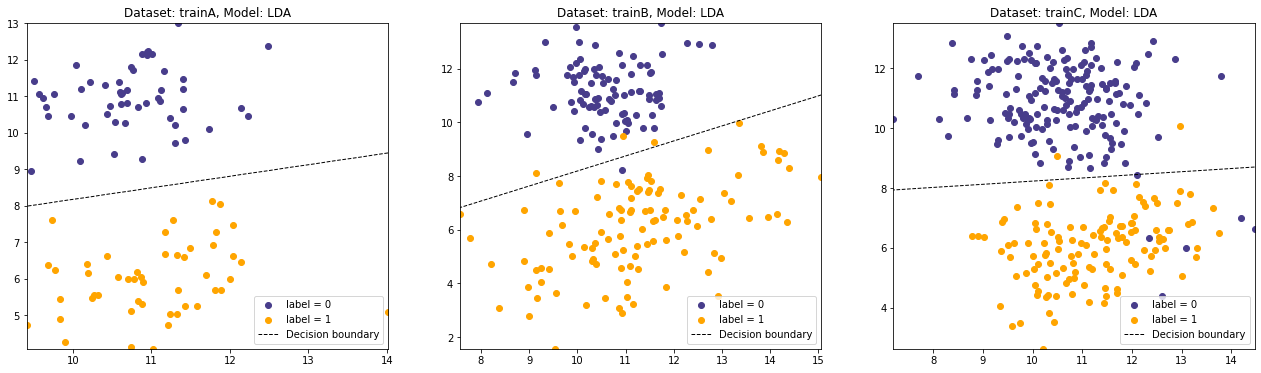

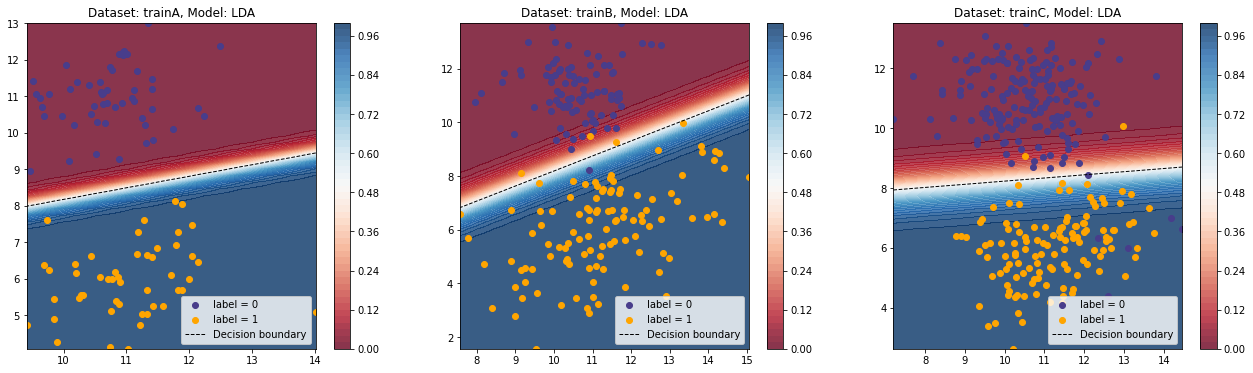

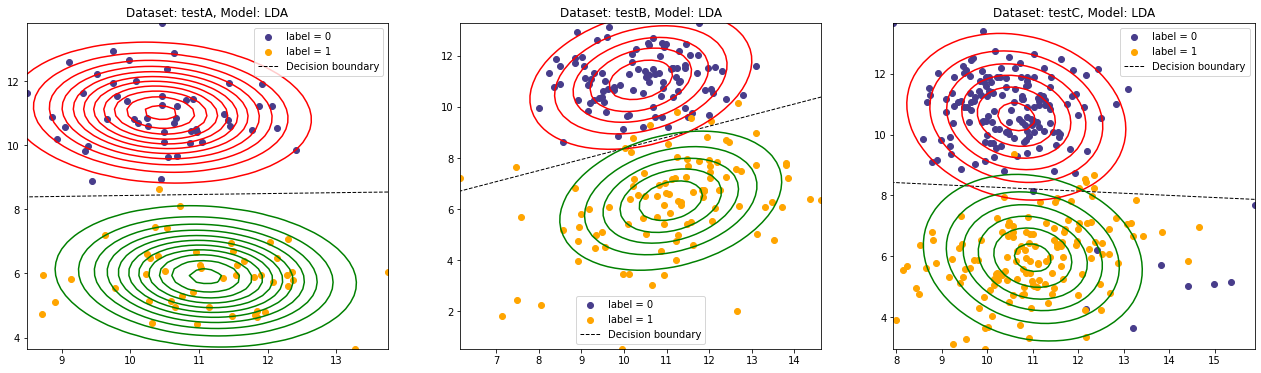

In [5]:
classification_results_with_plots(LinearDiscriminantAnalysis(), with_proba_level=False)
classification_results_with_plots(LinearDiscriminantAnalysis(), with_proba_level=True)
normal_parameters = plot_normal_distribution(LinearDiscriminantAnalysis(), data="test")

In [6]:
X_train, y_train = load_dataset("data/trainC")
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)

X_train_0 = X_train[y_train == 0] - model.mu_0
X_train_1 = X_train[y_train == 1] - model.mu_1

sigma_0 =  X_train_0.T @ X_train_0 / X_train_0.shape[0]
sigma_1 =  X_train_1.T @ X_train_1 / X_train_1.shape[0]

In [7]:
print("----- Joint covariance -----")
print(model.sigma)
print("----- Covariance only class 0 -----")
print(sigma_0)
print("----- Covariance only class 1 -----")
print(sigma_1)

----- Joint covariance -----
[[ 1.27823018 -0.06243809]
 [-0.06243809  1.66584186]]
----- Covariance only class 0 -----
[[ 1.28576019 -0.43356756]
 [-0.43356756  1.82602425]]
----- Covariance only class 1 -----
[[1.26768817 0.45714317]
 [0.45714317 1.44158652]]


---> We should consider a gaussian Mixture

### 1.2 Logistic Regression

In [8]:
def display_coefs(dataset_to_coefs: Dict[str, List[float]]) -> None:
    """
    Helper function to print the learnt coefficients of a model
    
    dataset_to_coefs: Dict[str, list[float]]
    """
    for dataset_name, coefs in dataset_to_coefs.items():
        print(f"Learnt parameters for {dataset_name}")
        print(f"Coef_0: {coefs[0]}, Coef_1: {coefs[1]}, Coef_2: {coefs[2]}")
        print()

In [9]:
class LogisticRegression:
    def __init__(self, method="gradient_descent"):
        self.method = method
        self.coef_ = None
        
    def fit(self, X, y, lr=0.01, n_iters=200):
        """
        Model fitting
        
        X: array, shape (n_samples, n_features)
        y: array, shape (n_samples, )
        lr (learning rate): float
        n_iters: int
        """
        if self.method == "irls":
            self.fit_irls(X, y, n_iters)
        elif self.method == "gradient_descent":
            self.fit_gradient_descent(X, y, lr, n_iters)
        else:
            raise ValueError("Fit method should be either gradient_descent or irls")
        return self
            
    def fit_gradient_descent(self, X, y, lr=0.01, n_iters=200):
        """
        Model fitting - using classic gradient descent
        
        X: array, shape (n_samples, n_features)
        y: array, shape (n_samples, )
        lr (learning rate): float
        n_iters: int
        """
        n_samples, n_features = X.shape
        X_bias = np.ones((n_samples, 1))
        X_aug = np.hstack([X_bias, X])
        
        self.coef_ = np.zeros(n_features + 1,)
        
        for i in range(n_iters):
            proba = self.predict_proba(X_aug, add_bias=False)
            current_gradient = (1 / n_samples) * X_aug.T @ (proba - y)
            self.coef_ -= lr * current_gradient
        return self
    
    def fit_irls(self, X, y, max_iter=200):
        """
        Model fitting - using IRLS algorithm
        
        X: array, shape (n_samples, n_features)
        y: array, shape (n_samples, )
        lr (learning rate): float
        n_iters: int
        """
        n_samples, n_features = X.shape
        X_bias = np.ones((n_samples, 1))
        X_aug = np.hstack([X_bias, X])
        
        self.coef_ = np.zeros(n_features + 1,)
        converged = False
        current_iter = 0
        
        while not converged and current_iter < max_iter:
            former_coef = np.copy(self.coef_)
            probas = self.predict_proba(X_aug, add_bias=False)
            grad = (1 / n_samples) * X_aug.T @ (y - probas)
            hessian = - X_aug.T @ np.diag(probas * (1 - probas))  @ X_aug
            hessian += 1e-6 * np.eye(hessian.shape[0])
            self.coef_ = self.coef_ - np.linalg.inv(hessian) @ grad
            current_iter += 1
            if np.linalg.norm(self.coef_ - former_coef) < 1e-3:
                converged = True  
        return self
    
    def predict(self, X, add_bias=True) -> np.ndarray:
        """
        Return the predicted label
        
        X: array, shape (n_samples, n_features)
        """
        return np.ravel(self.predict_proba(X, add_bias) > 0.5).astype(int)
    
    def predict_proba(self, X, add_bias=True) -> np.ndarray:
        """
        Returns p(y = 1 | X)
        
        X: array, shape (n_samples, n_features)
        add_bias: bool
        """
        if add_bias:
            X_bias = np.ones((X.shape[0], 1))
            X = np.hstack([X_bias, X])
        return self.sigmoid(X @ self.coef_)
    
    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """
        Compute sigmoid function
        """
        return 1 / (1 + np.exp(-z))
    
    def __str__(self) -> str:
        return f"Logistic Regression {self.method}"

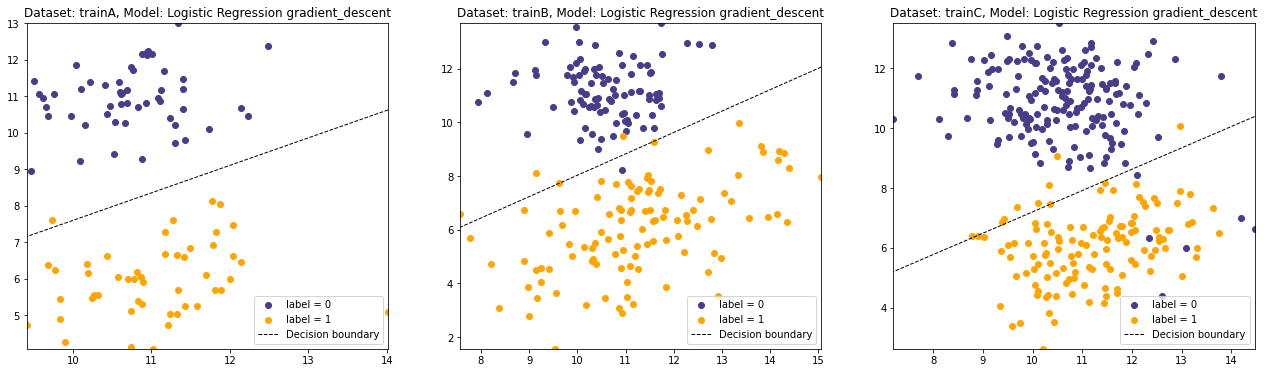

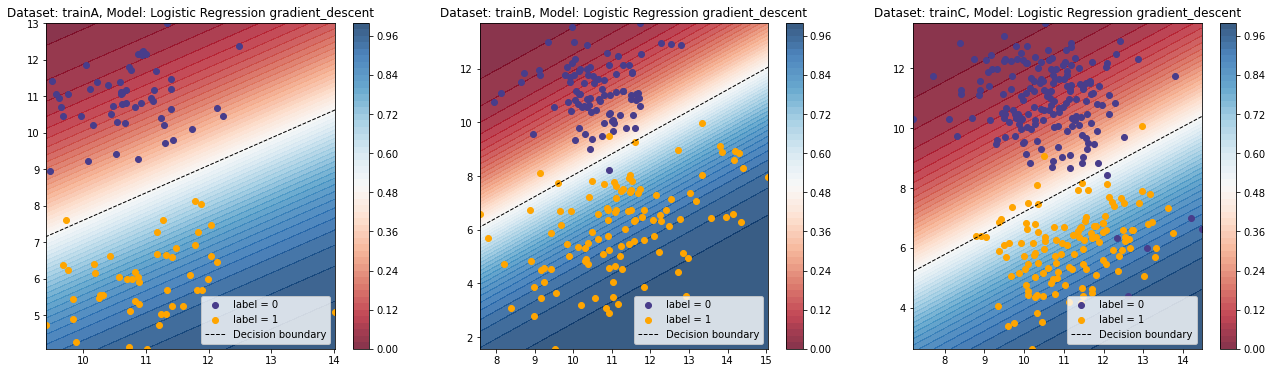

In [10]:
coefs = classification_results_with_plots(LogisticRegression(), with_proba_level=False)
_ = classification_results_with_plots(LogisticRegression(), with_proba_level=True)

In [11]:
print("----- Logistic regression results -----")
display_coefs(coefs)

----- Logistic regression results -----
Learnt parameters for trainA
Coef_0: 0.04815012922309037, Coef_1: 0.5603401735111518, Coef_2: -0.7437549187596779

Learnt parameters for trainB
Coef_0: 0.04392141151107772, Coef_1: 0.5636149209883324, Coef_2: -0.7074348722724652

Learnt parameters for trainC
Coef_0: 0.04225659648022708, Coef_1: 0.4804165218767354, Coef_2: -0.6731428818822772



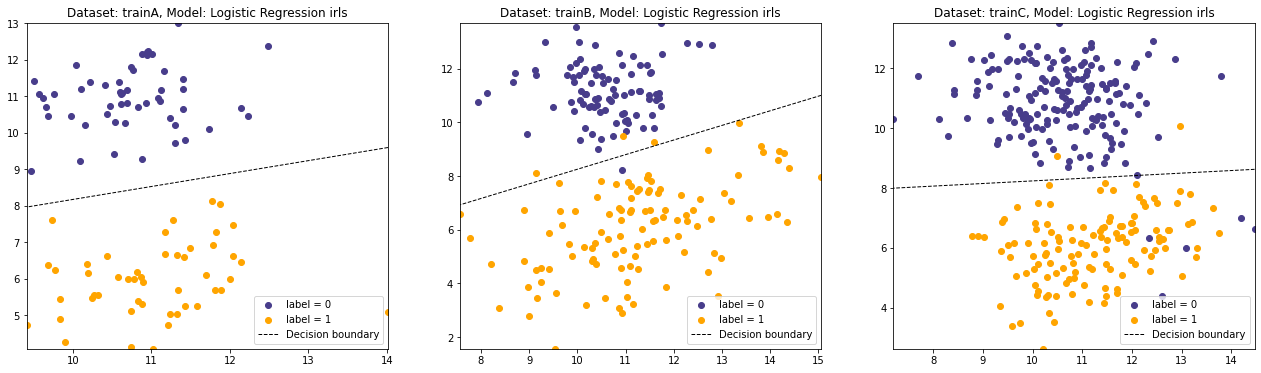

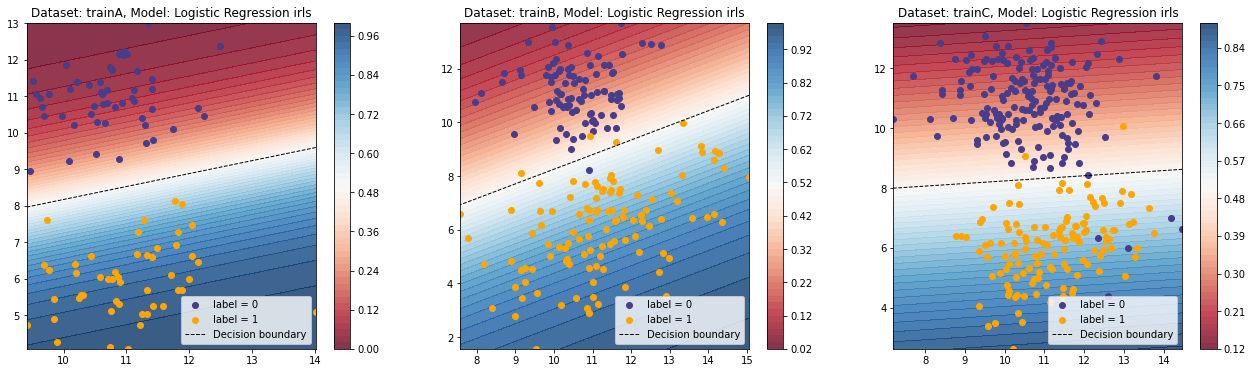

In [12]:
coefs = classification_results_with_plots(LogisticRegression(method="irls"), with_proba_level=False)
_ = classification_results_with_plots(LogisticRegression(method="irls"), with_proba_level=True)

In [13]:
print("----- Logistic regression IRLS results -----")
display_coefs(coefs)

----- Logistic regression IRLS results -----
Learnt parameters for trainA
Coef_0: 4.768518996928435, Coef_1: 0.364609854284257, Coef_2: -1.0295856687542704

Learnt parameters for trainB
Coef_0: 1.3191493192670372, Coef_1: 0.2554000001504422, Coef_2: -0.4693223014174838

Learnt parameters for trainC
Coef_0: 2.5457490066587676, Coef_1: 0.02996654618152417, Coef_2: -0.3454981534123532



### 1.3 Linear Regression

In [14]:
class LinearRegression():
    def __init__(self,):
        self.coef_ = None
        
    def fit(self, X, y):
        """
        Model fitting
        
        X: array, shape (n_samples, n_features)
        y: array, shape (n_samples, )
        """
        n_samples = X.shape[0]
        X_bias = np.ones((n_samples, 1))
        X_aug = np.hstack([X_bias, X])
        
        self.coef_ = np.linalg.pinv(X_aug.T @ X_aug) @ X_aug.T @ y
        return self
        
    def predict_proba(self, X, add_bias=True) -> np.ndarray:
        """
        Returns p(y = 1 | X)
        
        X: array, shape (n_samples, n_features)
        add_bias: bool
        """
        if add_bias:
            X_bias = np.ones((X.shape[0], 1))
            X_aug = np.hstack([X_bias, X])
        return X_aug @ self.coef_
        
    def predict(self, X, add_bias=True) -> np.ndarray:
        """
        Return the predicted label
        
        X: array, shape (n_samples, n_features)
        """
        return np.ravel(self.predict_proba(X, add_bias) > 0.5).astype(int)
    
    def __str__(self) -> str:
        return "Linear Regression"

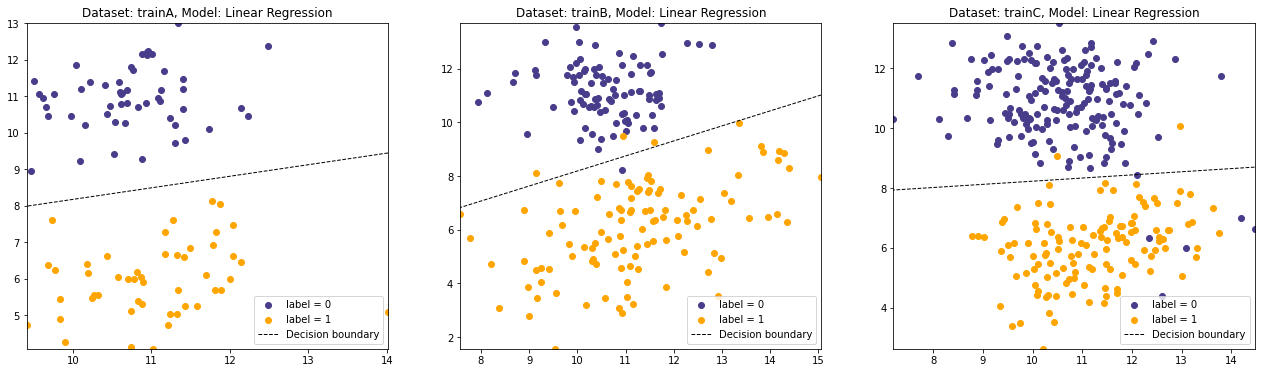

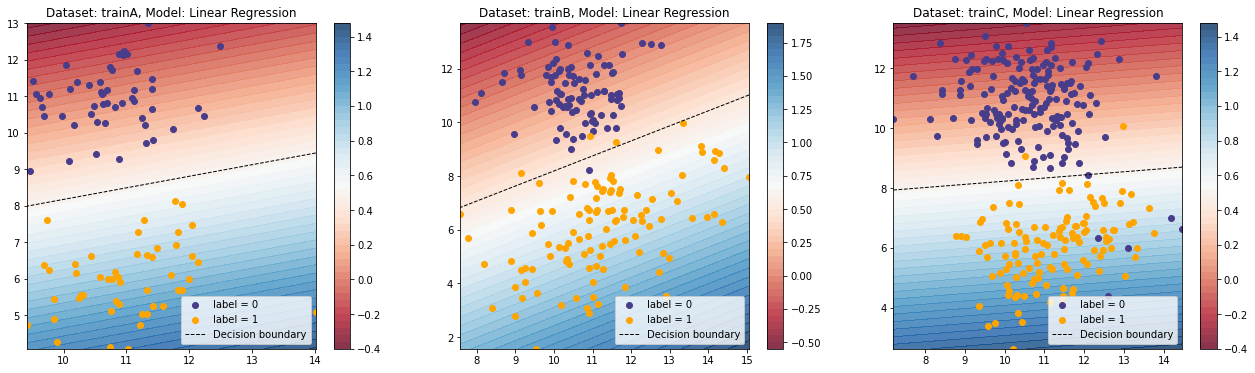

In [15]:
coefs = classification_results_with_plots(LinearRegression(), with_proba_level=False)
_ = classification_results_with_plots(LinearRegression(), with_proba_level=True)

In [16]:
print("----- Linear regression results -----")
display_coefs(coefs)

----- Linear regression results -----
Learnt parameters for trainA
Coef_0: 1.3834577395045762, Coef_1: 0.05582438270263192, Coef_2: -0.17636636316895793

Learnt parameters for trainB
Coef_0: 0.8824998417111514, Coef_1: 0.08258172475674404, Coef_2: -0.1475751701676048

Learnt parameters for trainC
Coef_0: 1.6401520597418164, Coef_1: 0.016754609691518697, Coef_2: -0.15897174225371047



### 1.4 Application

In [17]:
def get_classification_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean(y_true != y_pred)

def get_models_error():
    files_train = ["data/trainA", "data/trainB", "data/trainC"]
    files_test = ["data/testA", "data/testB", "data/testC"]
    models = [
        LinearDiscriminantAnalysis(), LogisticRegression(method="gradient_descent"), 
        LogisticRegression(method="irls"), LinearRegression()
    ]
    results_test = defaultdict(dict)
    results_train = defaultdict(dict)
    for file_train, file_test in zip(files_train, files_test):
        X_train, y_train = load_dataset(file_train)
        X_test, y_test = load_dataset(file_test)
        for model in models:
            model.fit(X_train, y_train)
            error_test = get_classification_error(y_test, model.predict(X_test))
            error_train = get_classification_error(y_train, model.predict(X_train))
            results_test[file_train[-1]][str(model)] = error_test
            results_train[file_train[-1]][str(model)] = error_train
    return results_test, results_train

In [18]:
results_test, results_train = get_models_error()
print("----- Error on test sets -----")
print(dict(results_test))
print()
print("----- Error on train sets -----")
print(dict(results_train))

----- Error on test sets -----
{'A': {'LDA': 0.01, 'Logistic Regression gradient_descent': 0.01, 'Logistic Regression irls': 0.01, 'Linear Regression': 0.01}, 'B': {'LDA': 0.045, 'Logistic Regression gradient_descent': 0.04, 'Logistic Regression irls': 0.045, 'Linear Regression': 0.045}, 'C': {'LDA': 0.04, 'Logistic Regression gradient_descent': 0.04666666666666667, 'Logistic Regression irls': 0.043333333333333335, 'Linear Regression': 0.04}}

----- Error on train sets -----
{'A': {'LDA': 0.0, 'Logistic Regression gradient_descent': 0.01, 'Logistic Regression irls': 0.0, 'Linear Regression': 0.0}, 'B': {'LDA': 0.02, 'Logistic Regression gradient_descent': 0.025, 'Logistic Regression irls': 0.02, 'Linear Regression': 0.02}, 'C': {'LDA': 0.02666666666666667, 'Logistic Regression gradient_descent': 0.04666666666666667, 'Logistic Regression irls': 0.023333333333333334, 'Linear Regression': 0.02666666666666667}}


In [19]:
def plot_simultaneous_decision_boundaries():
    file_names = [f"data/trainA", f"data/trainB", f"data/trainC"]
    
    fig, ax = plt.subplots(1, 3, figsize=(22, 6))    
    
    for i, file_name in enumerate(file_names):
        plt.subplot(1, 3, i + 1)
        X_train, y_train = load_dataset(file_name)
        lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
        logistic_regression = LogisticRegression().fit(X_train, y_train)
        logistic_regression_irls = LogisticRegression(method="irls").fit(X_train, y_train)
        linear_regression = LinearRegression().fit(X_train, y_train)
        
        # Plot the dataset as a 2D point cloud
        plt.scatter(
            X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1],
            c="darkslateblue", label="label = 0"
        )
        plt.scatter(
            X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1],
            c="orange", label="label = 1"
        )
        # Define a 2D grid using minimum and maximum values of features
        feature_1_min, feature_1_max = np.min(X_train[:,0]), np.max(X_train[:,0])
        feature_2_min, feature_2_max = np.min(X_train[:,1]), np.max(X_train[:,1])
        xx1, xx2 = np.meshgrid(np.linspace(feature_1_min, feature_1_max), np.linspace(feature_2_min, feature_2_max))
        grid = np.c_[np.ravel(xx1), np.ravel(xx2)]

        # Get p(y = 1 | x) for all points x in the grid
        probs_lda = lda.predict_proba(grid).reshape(xx1.shape)
        probs_logr = logistic_regression.predict_proba(grid, add_bias=True).reshape(xx1.shape)
        probs_logr_irls = logistic_regression_irls.predict_proba(grid, add_bias=True).reshape(xx1.shape)
        probs_lr = linear_regression.predict_proba(grid, add_bias=True).reshape(xx1.shape)

        # Plot the line corresponding to p(y = 1 | x) = 0.5 (or any proba_threshold)
        contour_lda = plt.contour(xx1, xx2, probs_lda, [0.5], linewidths=2, colors="black", linestyles="--")
        contour_lda.collections[0].set_label("LDA")

        contour_logr = plt.contour(xx1, xx2, probs_logr, [0.5], linewidths=2, colors="red", linestyles="--")
        contour_logr.collections[0].set_label("Logistic regression")
        
        contour_logr_irls = plt.contour(xx1, xx2, probs_logr_irls, [0.5], linewidths=2, colors="green", linestyles="--")
        contour_logr_irls.collections[0].set_label("Logistic regression IRLS")

        contour_lr = plt.contour(xx1, xx2, probs_lr, [0.5], linewidths=2, colors="blue", linestyles="--")
        contour_lr.collections[0].set_label("Linear regression")

        plt.title(f"Dataset: {file_name[-1]}, Decision boundaries comparison")
        plt.legend(loc='lower right')

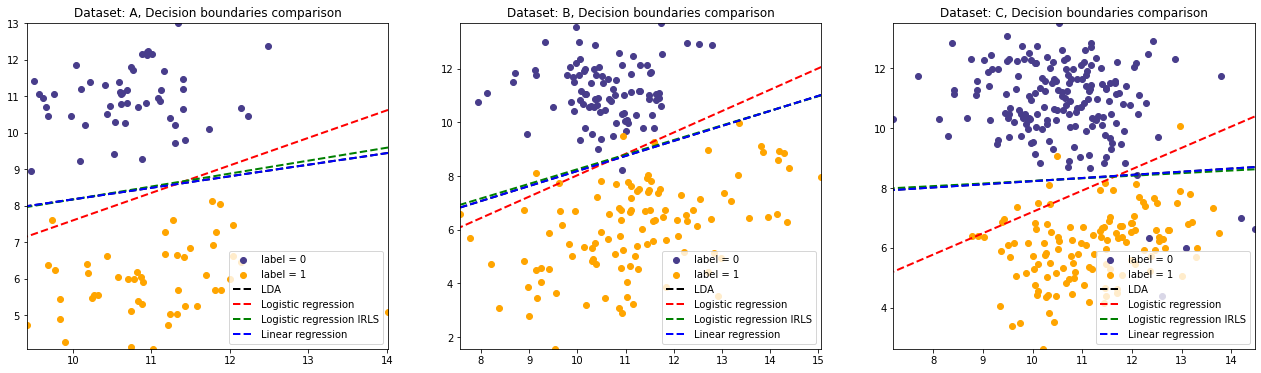

In [20]:
plot_simultaneous_decision_boundaries()

## 2 - Gaussian mixture models and EM

### 2.1 Math

The description of the EM algorithm and the justification of the update formulas are given in the report.

### 2.2 Implementation

In [21]:
class EM_GMM:
    def __init__(self, K):
        self.K = K
        self.pi = [None for _ in range(K)]
        self.mu = [None for _ in range(K)]
        self.sigma = [None for _ in range(K)]
        self.clusters_labels = None
    
    def initialize_random_clusters(self, X: np.ndarray) -> np.ndarray:
        """
        Initialize random clusters
        
        X: array, shape (n_samples, n_features)
        
        Output: array, shape(n_samples, self.K)
        """
        n_samples, n_features = X.shape
        cluster_assigments = np.random.choice(self.K, size=n_samples)
        initial_tau = np.zeros((n_samples, self.K))
        for i in range(n_samples):
            initial_tau[i][cluster_assigments[i]] = 1
        return initial_tau
        
    def e_step(self, X: np.ndarray) -> np.ndarray:
        """
        Compute the E-step
        
        X: array, shape (n_samples, n_features)
        
        Output: array, shape(n_samples, self.K)
        """
        n_samples, n_features = X.shape
        # Correspond to conditional probabilities of Z given X
        tau_coefficients = np.zeros((n_samples, self.K))
        
        for k in range(self.K):
            tau_coefficients[:, k] = self.pi[k] * self.normal_distribution(X, k)
        return tau_coefficients / np.sum(tau_coefficients, axis=1).reshape(-1, 1)
    
    def m_step(self, X: np.ndarray, tau: np.ndarray) -> None:
        """
        Compute the M-step
        
        X: array, shape (n_samples, n_features)
        tau: array, shape(n_samples, self.K)
        """
        n_samples = X.shape[0]
        self.pi = np.sum(tau, axis=0) / n_samples
        for k in range(self.K):
            tau_k = tau[:, k]
            normalized_factor = np.sum(tau_k)
            self.mu[k] = np.sum([tau_k[i] * X[i, :] for i in range(n_samples)], axis=0) / normalized_factor
            weighted_centered_X = [
                tau_k[i] * (X[i, :] - self.mu[k]).reshape(-1, 1) @  (X[i, :] - self.mu[k]).reshape(-1, 1).T
                for i in range(n_samples)
            ]
            self.sigma[k] = np.sum(weighted_centered_X, axis=0) / normalized_factor
        
    
    def get_loglikelihood(self, X: np.ndarray) -> float:
        """
        Return the data loglikelihood for current parameters
        
        X: array, shape (n_samples, n_features)
        """
        n_samples, n_features = X.shape
        normal_distribution_matrix = np.zeros((n_samples, self.K))
        for k in range(self.K):
            normal_distribution_matrix[:, k] = self.pi[k] * self.normal_distribution(X, k)
        log_sum_log_normal = np.log(np.sum(normal_distribution_matrix, axis=1))
        return np.sum(log_sum_log_normal)
              
    def fit(self, X, eps=1e-4, max_iter=200):
        """
        Model fitting
        
        X: array, shape (n_samples, n_features)
        eps: float (convergence tolerance)
        max_iter: int
        """
        
        # Initialize clusters:
        tau = self.initialize_random_clusters(X)
        
        converged = False
        current_iter = 0
        current_likelihood = - float("inf")
        while not converged and current_iter < max_iter:
            # M-step
            self.m_step(X, tau)
            
            # E-step
            tau = self.e_step(X)

            # Check for convergence
            new_likelihood = self.get_loglikelihood(X)
            if abs(new_likelihood - current_likelihood) < eps:
                converged = True
                print(f"Converged at iteration {current_iter}")
            current_likelihood = new_likelihood
            current_iter += 1
            
        last_tau = self.e_step(X)
        self.clusters_labels = np.argmax(last_tau, axis=1)
                
    def normal_distribution(self, x: np.ndarray, label: int) -> np.ndarray:
        """
        Return PDF of normal distribution according to the class label
        
        x: array, shape (n_samples, n_features)
        label: int (class label)
        """
        mu = self.mu[label]
        sigma = self.sigma[label]
        sigma_inv = np.linalg.pinv(sigma + 1e-4 * np.eye(sigma.shape[0]))
        normalize_factor = 1 / np.sqrt(2 * np.pi * np.linalg.det(sigma))
        return np.array([normalize_factor * np.exp(- 0.5 * (x_i - mu).T @ sigma_inv @ (x_i - mu)) for x_i in x])
    
    def __str__(self) -> str:
        return "EM algorithm - GMM"
    

In [22]:
def plot_normal_distribution(data="train", proba_threshold=0.5):
    """
    Plot the normals distributions contour of the GMM (only applied to the datasets with 2D points)
    """
    files = [f"data/{data}A", f"data/{data}B", f"data/{data}C"]
    
    fig, ax = plt.subplots(1, len(files), figsize=(22, 6))
    for i, file_name in enumerate(files):
        plt.subplot(1, len(files), i + 1)
        X_train, y_train = load_dataset(file_name)
        model = EM_GMM(2)
        model.fit(X_train, eps=1e-6, max_iter=200)
        
        # Plot the dataset as a 2D point cloud
        plt.scatter(
            X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1],
            c="darkslateblue", label="label = 0"
        )
        plt.scatter(
            X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1],
            c="orange", label="label = 1"
        )
        # Define a 2D grid using minimum and maximum values of features
        feature_1_min, feature_1_max = np.min(X_train[:,0]), np.max(X_train[:,0])
        feature_2_min, feature_2_max = np.min(X_train[:,1]), np.max(X_train[:,1]),
        xx1, xx2 = np.meshgrid(np.linspace(feature_1_min, feature_1_max), np.linspace(feature_2_min, feature_2_max))
        grid = np.c_[np.ravel(xx1), np.ravel(xx2)]
        raveled_grid = np.concatenate([np.ravel(xx1).reshape(-1,1), np.ravel(xx2).reshape(-1, 1)], axis=1)
        # Plot the contour of the normal distributions
        normal_distrib_0 = model.normal_distribution(raveled_grid, 0).reshape(xx1.shape)
        normal_distrib_1 = model.normal_distribution(raveled_grid, 1).reshape(xx1.shape)
        plt.contour(xx1,xx2,normal_distrib_0, np.linspace(0, 0.5, 15), colors="red")
        plt.contour(xx1,xx2,normal_distrib_1, np.linspace(0, 0.5, 15), colors="green")
            
        train_set_name = file_name.split("/")[1]
        plt.title(f"Dataset: {train_set_name}, Model: {model}")


Converged at iteration 30
Converged at iteration 31
Converged at iteration 46


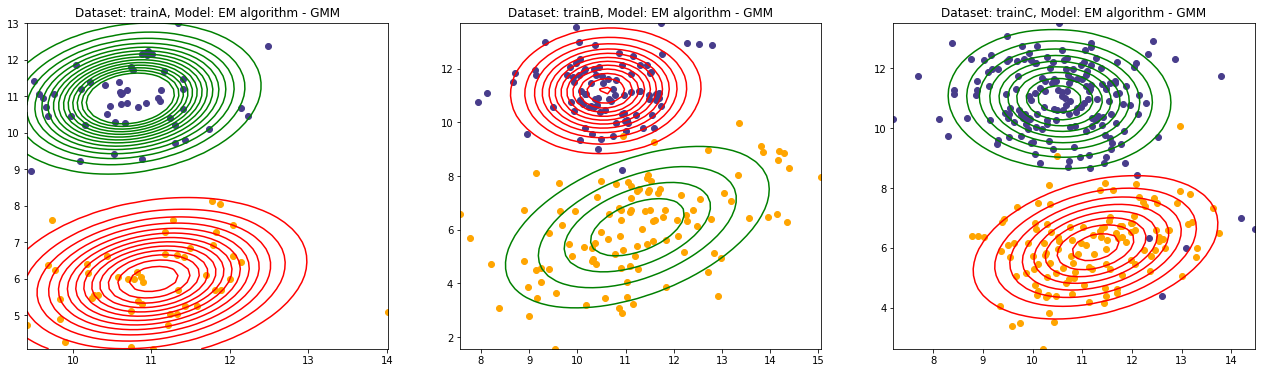

In [23]:
plot_normal_distribution()

### 2.3 Application

Let's load the decathlon dataset:

In [24]:
df = pyreadr.read_r('data/decathlon.rdata')["X"]
X = df.to_numpy()
df.head()

,100m,Long.jump,Shot.put,High.jump,400m,110m.hurdle,Discus,Pole.vault,Javeline,1500m
rownames,,,,,,,,,,
SEBRLE,11.04,7.58,14.83,2.07,49.81,14.69,43.75,5.02,63.19,291.7
CLAY,10.76,7.40,14.26,1.86,49.37,14.05,50.72,4.92,60.15,301.5
KARPOV,11.02,7.30,14.77,2.04,48.37,14.09,48.95,4.92,50.31,300.2
BERNARD,11.02,7.23,14.25,1.92,48.93,14.99,40.87,5.32,62.77,280.1
YURKOV,11.34,7.09,15.19,2.10,50.42,15.31,46.26,4.72,63.44,276.4


Let's fit a Gaussian Mixture Models with 3 components on X:

In [25]:
K = 3
gmm_decathlon = EM_GMM(K)
gmm_decathlon.fit(X, eps=1e-6, max_iter=50)

Using the maximum a posteriori, we can assign a cluster to each datapoint, and look at the groups of athletes formed by these clusters:

In [26]:
groups_gmm = defaultdict(list)
for i, name in enumerate(list(df.index)):
    groups_gmm[gmm_decathlon.clusters_labels[i]].append(name)
for i in sorted(groups_gmm.keys()):
    print(f"----- Group {i} -----")
    print(groups_gmm[i])

----- Group 0 -----
['CLAY', 'YURKOV', 'WARNERS', 'ZSIVOCZKY', 'NOOL', 'Warners', 'Hernu', 'Averyanov', 'Ojaniemi', 'Qi', 'Drews', 'Terek', 'Gomez', 'Turi', 'Korkizoglou', 'Casarsa']
----- Group 1 -----
['SEBRLE', 'BERNARD', 'McMULLEN', 'HERNU', 'BARRAS', 'BOURGUIGNON', 'Sebrle', 'Clay', 'Karpov', 'Macey', 'Nool', 'Schoenbeck', 'Barras', 'Smirnov', 'Parkhomenko']
----- Group 2 -----
['KARPOV', 'MARTINEAU', 'Zsivoczky', 'Bernard', 'Schwarzl', 'Pogorelov', 'Smith', 'Lorenzo', 'Karlivans', 'Uldal']


In [27]:
df_group_0 = df.loc[groups_gmm[0]]
print("----- Cluster 0 characteristics -----")
print(df_group_0.describe())
print()

df_group_1 = df.loc[groups_gmm[1]]
print("----- Cluster 1 characteristics -----")
print(df_group_1.describe())
print()

df_group_2 = df.loc[groups_gmm[2]]
print("----- Cluster 2 characteristics -----")
print(df_group_2.describe())

----- Cluster 0 characteristics -----
            100m  Long.jump   Shot.put  High.jump       400m  110m.hurdle  \
count  16.000000  16.000000  16.000000  16.000000  16.000000    16.000000   
mean   10.982500   7.250625  14.259375   1.960000  49.636875    14.602500   
std     0.251038   0.268563   0.760057   0.065013   1.370638     0.506195   
min    10.550000   6.680000  12.680000   1.850000  47.970000    14.010000   
25%    10.835000   7.085000  13.602500   1.940000  48.665000    14.215000   
50%    11.015000   7.285000  14.460000   1.955000  49.285000    14.400000   
75%    11.115000   7.385000  14.837500   1.987500  49.895000    15.037500   
max    11.360000   7.740000  15.190000   2.100000  53.200000    15.390000   

          Discus  Pole.vault   Javeline       1500m  
count  16.000000   16.000000  16.000000   16.000000  
mean   43.545000    4.737500  56.859375  280.610000  
std     3.630724    0.246238   3.814153   14.547648  
min    37.920000    4.400000  50.620000  264.350000 

Below is given another model which tries to look for 3 clusters, but only looking at two features: "1500m" and "Javeline".

In [28]:
columns = ["1500m", "Javeline"]
Y = df[columns].to_numpy()

K = 3
gmm_decathlon_two_columns = EM_GMM(K)
gmm_decathlon_two_columns.fit(Y, eps=1e-3, max_iter=500)

Converged at iteration 27


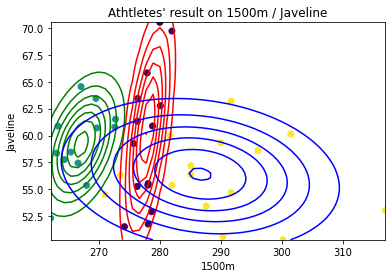

In [29]:
plt.scatter(*Y.T, c=gmm_decathlon_two_columns.clusters_labels)
plt.title("Athtletes' result on 1500m / Javeline")
plt.ylabel("Javeline")
plt.xlabel("1500m")

feature_1_min, feature_1_max = np.min(Y[:,0]), np.max(Y[:,0])
feature_2_min, feature_2_max = np.min(Y[:,1]), np.max(Y[:,1]),
xx1, xx2 = np.meshgrid(np.linspace(feature_1_min, feature_1_max), np.linspace(feature_2_min, feature_2_max))
grid = np.c_[np.ravel(xx1), np.ravel(xx2)]
raveled_grid = np.concatenate([np.ravel(xx1).reshape(-1,1), np.ravel(xx2).reshape(-1, 1)], axis=1)

normal_distrib_0 = gmm_decathlon_two_columns.normal_distribution(raveled_grid, 0).reshape(xx1.shape)
normal_distrib_1 = gmm_decathlon_two_columns.normal_distribution(raveled_grid, 1).reshape(xx1.shape)
normal_distrib_2 = gmm_decathlon_two_columns.normal_distribution(raveled_grid, 2).reshape(xx1.shape)
plt.contour(xx1,xx2,normal_distrib_0, 7, colors="red")
plt.contour(xx1,xx2,normal_distrib_1, 7, colors="green")
plt.contour(xx1,xx2,normal_distrib_2, 7, colors="blue")

In [30]:
groups_gmm = defaultdict(list)
for i, name in enumerate(list(df.index)):
    groups_gmm[gmm_decathlon_two_columns.clusters_labels[i]].append(name)
for i in sorted(groups_gmm.keys()):
    print(f"----- Group {i} -----")
    print(groups_gmm[i])

----- Group 0 -----
['BERNARD', 'YURKOV', 'WARNERS', 'Sebrle', 'Clay', 'Karpov', 'Warners', 'Nool', 'Bernard', 'Schoenbeck', 'Ojaniemi', 'Drews', 'Parkhomenko', 'Karlivans']
----- Group 1 -----
['ZSIVOCZKY', 'MARTINEAU', 'NOOL', 'Macey', 'Zsivoczky', 'Hernu', 'Barras', 'Smith', 'Smirnov', 'Qi', 'Gomez', 'Lorenzo']
----- Group 2 -----
['SEBRLE', 'CLAY', 'KARPOV', 'McMULLEN', 'HERNU', 'BARRAS', 'BOURGUIGNON', 'Schwarzl', 'Pogorelov', 'Averyanov', 'Terek', 'Turi', 'Korkizoglou', 'Uldal', 'Casarsa']


In [31]:
df_group_0 = df.loc[groups_gmm[0]][columns]
print("----- Cluster 0 characteristics -----")
print(df_group_0.describe())
print()

df_group_1 = df.loc[groups_gmm[1]][columns]
print("----- Cluster 1 characteristics -----")
print(df_group_1.describe())
print()

df_group_2 = df.loc[groups_gmm[2]][columns]
print("----- Cluster 2 characteristics -----")
print(df_group_2.describe())

----- Cluster 0 characteristics -----
            1500m   Javeline
count   14.000000  14.000000
mean   277.911429  59.725714
std      2.024902   6.284936
min    274.210000  51.530000
25%    276.347500  55.300000
50%    278.075000  60.075000
75%    278.782500  63.272500
max    282.000000  70.520000

----- Cluster 1 characteristics -----
            1500m   Javeline
count   12.000000  12.000000
mean   267.046667  59.301667
std      3.593422   3.409401
min    262.100000  52.330000
25%    264.090000  57.680000
50%    266.845000  59.585000
75%    269.580000  61.040000
max    272.740000  64.550000

----- Cluster 2 characteristics -----
            1500m   Javeline
count   15.000000  15.000000
mean   289.646667  56.213333
std     11.413721   3.632781
min    271.020000  50.310000
25%    283.550000  53.980000
50%    290.010000  56.320000
75%    293.910000  58.980000
max    317.000000  63.190000


To finish this analysis, let's compare the results with a KMeans (3 clusters), fitted with the two same features:

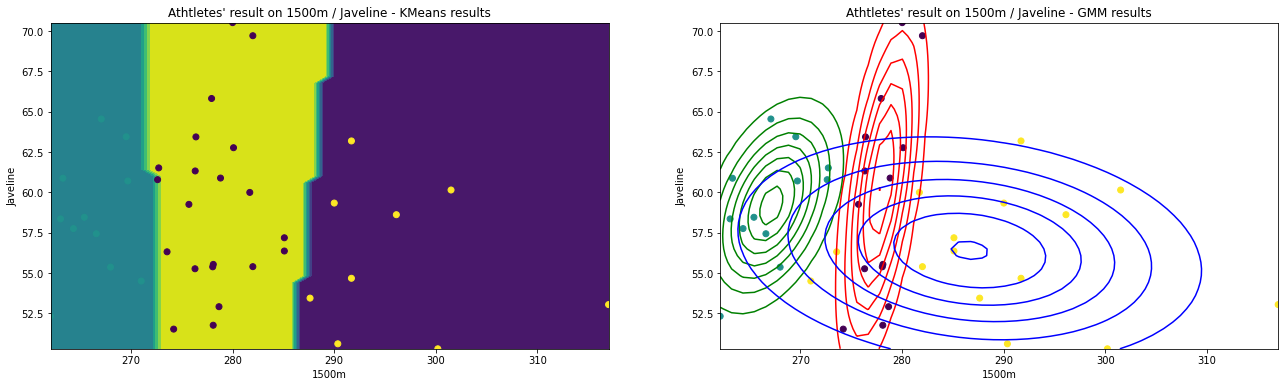

In [32]:
K = 3
kmeans_decathlon_two_columns = KMeans(K)
kmeans_decathlon_two_columns.fit(Y)

fig, ax = plt.subplots(1, 2, figsize=(22, 6))

plt.subplot(1, 2, 1)
kmeans_prediction = kmeans_decathlon_two_columns.predict(raveled_grid).reshape(xx1.shape)
plt.contourf(kmeans_prediction, extent=(feature_1_min, feature_1_max, feature_2_min, feature_2_max))
plt.scatter(*Y.T, c=1 - kmeans_decathlon_two_columns.predict(Y))
plt.title("Athtletes' result on 1500m / Javeline - KMeans results")
plt.ylabel("Javeline")
plt.xlabel("1500m")

plt.subplot(1, 2, 2)
plt.scatter(*Y.T, c=gmm_decathlon_two_columns.clusters_labels)
plt.title("Athtletes' result on 1500m / Javeline - GMM results")
plt.ylabel("Javeline")
plt.xlabel("1500m")

plt.contour(xx1,xx2,normal_distrib_0, 7, colors="red")
plt.contour(xx1,xx2,normal_distrib_1, 7, colors="green")
plt.contour(xx1,xx2,normal_distrib_2, 7, colors="blue")